In [10]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


main_dir = os.getcwd() + os.sep
data_extended_name = os.path.join(main_dir, 'match_vectors_extended.csv')  # change if file in different place
ratio = 0.8

np.random.seed(0)


In [11]:
def gen_quadratic_features(X):
    """
    For each sample x, form [x, outer(x,x).flatten()] -> returns array (n_samples, n_features + n_features^2)
    """
    new = []
    for x in X:
        quad = np.outer(x, x).flatten()
        new.append(np.concatenate([x, quad]))
    new = np.array(new)
    print("Quadratic feature shape:", new.shape)
    return new


def plot_prediction(x_test, y_test, y_predict, predict_prob, title=''):
    """Plot predicted probabilities (top) and true vs predicted (bottom)."""
    acc = np.mean(y_test == y_predict)
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    axs[0].plot(predict_prob)
    axs[0].set_ylabel('h(x)')
    axs[0].set_title(title if title else 'Prediction probabilities')
    axs[1].plot(y_test, 'ro', markersize=4, label='True')
    axs[1].plot(y_predict, 'bo', markersize=2, label=f'Predicted ({acc*100:.2f}%)')
    axs[1].legend()
    axs[1].set_ylabel('label')
    axs[1].set_xlabel('test sample index')
    plt.tight_layout()
    plt.show()


def plot_confusion(y_true, y_pred, title='Confusion Matrix'):
    """Plot labeled confusion matrix with labels [-1,0,1]."""
    labels = [-1, 0, 1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(title)
    plt.show()


In [12]:
# Load dataset and split (train/test)
data = shuffle(np.genfromtxt(data_extended_name, delimiter=',', skip_header=1), random_state=0)

# X: all columns except last, y: last column
X = data[:, :-1]
y = data[:, -1]

i_split = int(len(y) * ratio)
X_train = X[:i_split].copy()
X_test = X[i_split:].copy()
y_train = y[:i_split].copy()
y_test = y[i_split:].copy()

print("Dataset size:", len(y))
print("Train / Test sizes:", len(y_train), "/", len(y_test))


Dataset size: 3791
Train / Test sizes: 3032 / 759


In [13]:
# Scale features (Important: scale before training / before quadratic expansion)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Build quadratic features from the scaled data (stack so slicing is easy)
X_all_scaled = np.vstack([X_train_scaled, X_test_scaled])
X_quad_all = gen_quadratic_features(X_all_scaled)
X_quad_train = X_quad_all[:i_split]
X_quad_test  = X_quad_all[i_split:]


Quadratic feature shape: (3791, 78680)


In [14]:
# tie-as-loss and tie-as-win labels (preserves original logic)
# y_t_is_L: treat draw as loss (draw/loss => 0, win => 1)
# y_t_is_W: treat draw as win (draw/win => 0, loss => 1)
y_t_is_L = np.where(y_train < 1, 0, 1).astype(int)
y_t_is_W = np.where(y_train > -1, 0, 1).astype(int)

# Train binary classifiers (layer-1 in original code)
t_is_L_clf = LogisticRegression(solver='lbfgs', C=1e4, tol=1e-6, max_iter=20000)
t_is_W_clf = LogisticRegression(solver='lbfgs', C=1e4, tol=1e-6, max_iter=20000)

t_is_L_clf.fit(X_train_scaled, y_t_is_L)
t_is_W_clf.fit(X_train_scaled, y_t_is_W)

print("Layer-1 binary classifiers trained.")


Layer-1 binary classifiers trained.


🔹 Multinomial Accuracy (Test): 0.541501976284585
🔹 Multinomial Accuracy (Train): 0.6470976253298153


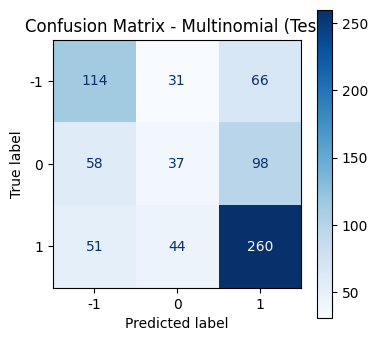

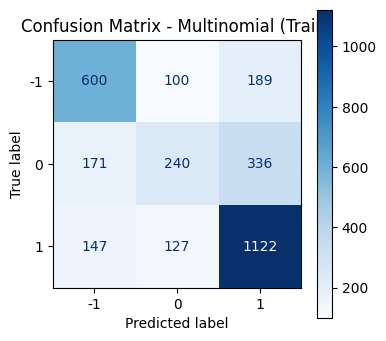

=== Test Classification Report ===
              precision    recall  f1-score   support

        -1.0     0.5112    0.5403    0.5253       211
         0.0     0.3304    0.1917    0.2426       193
         1.0     0.6132    0.7324    0.6675       355

    accuracy                         0.5415       759
   macro avg     0.4849    0.4881    0.4785       759
weighted avg     0.5129    0.5415    0.5200       759

=== Train Classification Report ===
              precision    recall  f1-score   support

        -1.0     0.6536    0.6749    0.6641       889
         0.0     0.5139    0.3213    0.3954       747
         1.0     0.6812    0.8037    0.7374      1396

    accuracy                         0.6471      3032
   macro avg     0.6163    0.6000    0.5990      3032
weighted avg     0.6319    0.6471    0.6317      3032



In [15]:
# Multinomial logistic regression on linear features
clf_multi = LogisticRegression(solver='lbfgs', C=1e4, tol=1e-6, max_iter=20000)
clf_multi.fit(X_train_scaled, y_train)

pred_test = clf_multi.predict(X_test_scaled)
pred_train = clf_multi.predict(X_train_scaled)
probs_train = clf_multi.predict_proba(X_train_scaled)
probs_test  = clf_multi.predict_proba(X_test_scaled)

print("🔹 Multinomial Accuracy (Test):", np.mean(pred_test == y_test))
print("🔹 Multinomial Accuracy (Train):", np.mean(pred_train == y_train))

# Confusion matrices and classification reports
plot_confusion(y_test, pred_test, "Confusion Matrix - Multinomial (Test)")
plot_confusion(y_train, pred_train, "Confusion Matrix - Multinomial (Train)")

print("=== Test Classification Report ===")
print(classification_report(y_test, pred_test, digits=4))
print("=== Train Classification Report ===")
print(classification_report(y_train, pred_train, digits=4))

# Optional: visual probability / label plot (similar to original plot_prediction)
# plot_prediction(X_test_scaled, y_test, pred_test, probs_test, title='multinomial_linear')


🔹 Probability-feature accuracy (test): 0.5428194993412385


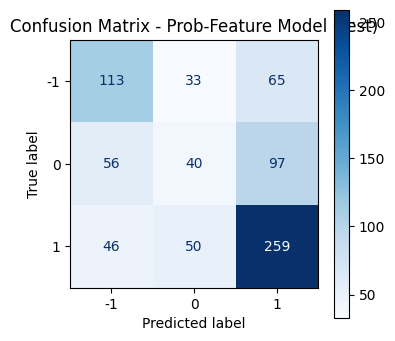

=== Classification Report (Prob-Feature Model) ===
              precision    recall  f1-score   support

        -1.0     0.5256    0.5355    0.5305       211
         0.0     0.3252    0.2073    0.2532       193
         1.0     0.6152    0.7296    0.6675       355

    accuracy                         0.5428       759
   macro avg     0.4887    0.4908    0.4837       759
weighted avg     0.5165    0.5428    0.5241       759



In [16]:
# use clf_multi.predict_proba as features for another logistic regression
clf_multi_prob_fts = LogisticRegression(solver='lbfgs', C=1e4, tol=1e-6, max_iter=20000)
clf_multi_prob_fts.fit(probs_train, y_train)

pred_probfts = clf_multi_prob_fts.predict(probs_test)
print("🔹 Probability-feature accuracy (test):", np.mean(pred_probfts == y_test))

plot_confusion(y_test, pred_probfts, "Confusion Matrix - Prob-Feature Model (Test)")
print("=== Classification Report (Prob-Feature Model) ===")
print(classification_report(y_test, pred_probfts, digits=4))


🔹 Quadratic multinomial Accuracy (Test): 0.47035573122529645
🔹 Quadratic multinomial Accuracy (Train): 1.0


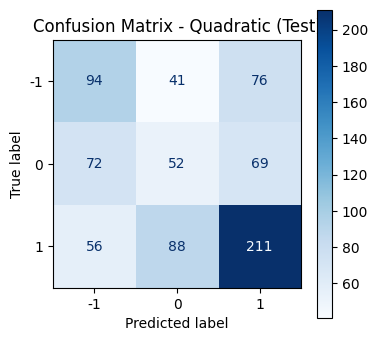

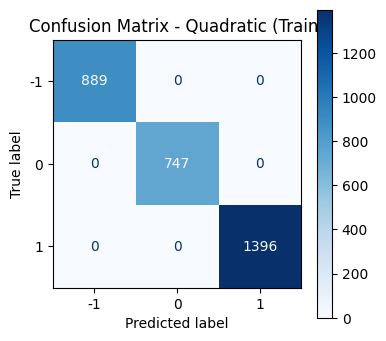

=== Test Classification Report (Quadratic) ===
              precision    recall  f1-score   support

        -1.0     0.4234    0.4455    0.4342       211
         0.0     0.2873    0.2694    0.2781       193
         1.0     0.5927    0.5944    0.5935       355

    accuracy                         0.4704       759
   macro avg     0.4345    0.4364    0.4353       759
weighted avg     0.4680    0.4704    0.4690       759

=== Train Classification Report (Quadratic) ===
              precision    recall  f1-score   support

        -1.0     1.0000    1.0000    1.0000       889
         0.0     1.0000    1.0000    1.0000       747
         1.0     1.0000    1.0000    1.0000      1396

    accuracy                         1.0000      3032
   macro avg     1.0000    1.0000    1.0000      3032
weighted avg     1.0000    1.0000    1.0000      3032



In [17]:
#  Quadratic feature model (same approach as original)
clf_multi_quadratic = LogisticRegression(solver='lbfgs', C=1e4, tol=1e-6, max_iter=20000)
clf_multi_quadratic.fit(X_quad_train, y_train)

pred_quad_test  = clf_multi_quadratic.predict(X_quad_test)
pred_quad_train = clf_multi_quadratic.predict(X_quad_train)

print("🔹 Quadratic multinomial Accuracy (Test):", np.mean(pred_quad_test == y_test))
print("🔹 Quadratic multinomial Accuracy (Train):", np.mean(pred_quad_train == y_train))

plot_confusion(y_test, pred_quad_test, "Confusion Matrix - Quadratic (Test)")
plot_confusion(y_train, pred_quad_train, "Confusion Matrix - Quadratic (Train)")

print("=== Test Classification Report (Quadratic) ===")
print(classification_report(y_test, pred_quad_test, digits=4))
print("=== Train Classification Report (Quadratic) ===")
print(classification_report(y_train, pred_quad_train, digits=4))


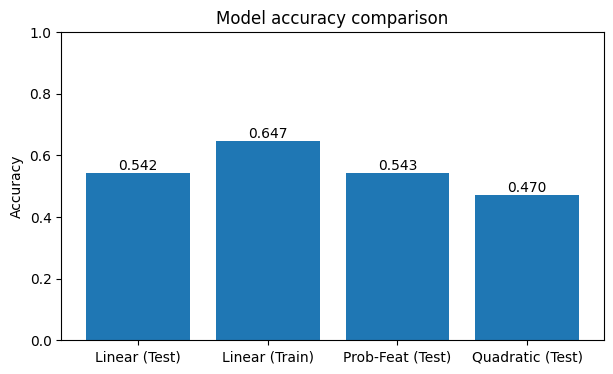

In [18]:
#  Accuracy comparison (simple bar chart)
acc_linear_test = np.mean(pred_test == y_test)
acc_linear_train = np.mean(pred_train == y_train)
acc_prob_test = np.mean(pred_probfts == y_test)
acc_quad_test = np.mean(pred_quad_test == y_test)

labels = ['Linear (Test)', 'Linear (Train)', 'Prob-Feat (Test)', 'Quadratic (Test)']
values = [acc_linear_test, acc_linear_train, acc_prob_test, acc_quad_test]

plt.figure(figsize=(7,4))
bars = plt.bar(labels, values)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.title('Model accuracy comparison')
for b,v in zip(bars, values):
    plt.text(b.get_x() + b.get_width()/2, v + 0.01, f"{v:.3f}", ha='center')
plt.show()
